In [1]:
# Library import cell

import numpy as np
#import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import itertools
from scipy.optimize import curve_fit
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
# Function cell

def generate_random_binary_string(length):
    binary_string = ''.join(np.random.choice(['0', '1'], size=length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}
    if n_tasks > np.power(2, len_taskcode):
        print("Error: n_tasks is too large")
        return False
    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)
        if binary_string not in unique_strings:
            unique_strings.add(binary_string)
            integer_list = np.random.choice(range(len_message), size=num_checks, replace=False).tolist()
            tasks_dict[binary_string] = integer_list
    return tasks_dict

'''
def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict)) # modify this line to introduce a prob dist
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]
  '''

# Currently following a Zipfian distribution
def generate_dataset(tasks_dict, num_samples):
    data = np.zeros((num_samples, len_taskcode + len_message))
    value = np.zeros(num_samples)
    
    task_list = list(tasks_dict)
    rank = np.arange(1, len(task_list) + 1)
    #probabilities = [1/(x**2) for x in rank]
    #probabilities = [np.exp(-0.1*x) for x in rank]
    #probabilities = [0.9, 0.09, 0.009, 0.001]
    probabilities = [1/(2**x) for x in rank]
    task_probabilities = probabilities / np.sum(probabilities)  # normalize probabilities
    print('tasks dict = ', tasks_dict)
    print('task_probabilities = ', task_probabilities)
    for i in range(num_samples):
        rand_task = np.random.choice(task_list, p=task_probabilities)
        rand_checkbits = tasks_dict[rand_task]
        message = generate_random_binary_string(len_message)
        parity_bit = 0
        for j in rand_checkbits:
            parity_bit += int(message[j])
        parity = parity_bit % 2
        data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
        value[i] = parity
    
    return [data, value]

def generate_dataset_for_task(task_code, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = task_code
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# IS NOT USING BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y

tasks dict =  {'11011101': [0, 6, 5], '00101001': [1, 3, 7], '01110001': [3, 6, 2], '01100111': [4, 7, 2], '00010000': [7, 0, 2], '01001001': [5, 2, 0], '01001010': [2, 7, 1], '10000000': [6, 5, 0], '00100111': [6, 5, 2], '10001010': [4, 3, 0], '11000100': [2, 0, 5], '01010010': [6, 4, 3], '10110011': [0, 2, 5], '11000011': [4, 1, 2], '01000111': [1, 0, 3], '10110101': [1, 7, 0]}
task_probabilities =  [5.00007630e-01 2.50003815e-01 1.25001907e-01 6.25009537e-02
 3.12504768e-02 1.56252384e-02 7.81261921e-03 3.90630961e-03
 1.95315480e-03 9.76577401e-04 4.88288701e-04 2.44144350e-04
 1.22072175e-04 6.10360876e-05 3.05180438e-05 1.52590219e-05]
100000 samples


100%|██████████| 1000/1000 [8:25:48<00:00, 30.35s/it]   


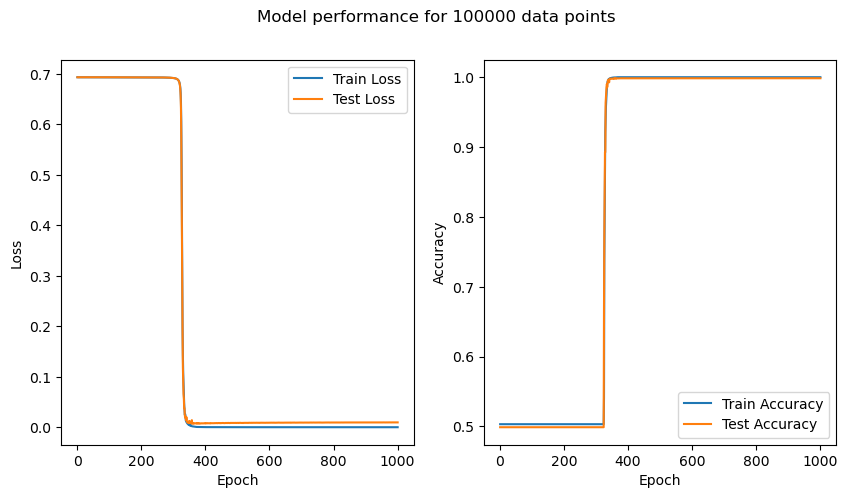

Total model parameters = 399361


In [92]:
# Define the probability distribution applied to tasks when they are being selected

# Parameters
n_tasks = 16 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 8  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=3, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples_list = [100000]
samples_per_task = 100
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 1000
test_frac = 0.2
num_layers = 8
hidden_size = 256

for num_samples in num_samples_list:
    # Train the model
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message) # Moved intentionally earlier
    #tasks_dict = {'10010000': [4,2,5], '01001011': [1,3,7]}
    #print("tasks_dict = ", tasks_dict.items())
    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    train_df, test_df = train_test_split(df, test_size=test_frac)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    print(f'{num_samples} samples')

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy

        # Find accuracy data
        tasks_list = list(tasks_dict.keys())
        for i in range(n_tasks):
          task_code = tasks_list[i]
          #print(f"task_code = ", task_code)
          [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
          #print(data_per_task)
          df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
          #print(df_per_task)
          dataset_per_task = CustomDataset(df_per_task)
          loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
          model.eval()
          task_correct = 0
          task_total = 0
          with torch.no_grad():
            for inputs, labels in loader_per_task:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                task_correct += (predictions == labels).sum().item()
                task_total += labels.size(0)
                #print(f'inputs = ', inputs)
                #print(f'labels.size(0) = ', labels.size(0))

                #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
                #test_loss += loss.item() * inputs.size(0)
            task_accuracy = task_correct / task_total
            #print(f"task_accuracy = ", task_accuracy)
            accuracy_array[(i, epoch)] = task_accuracy
        #print(f"accuracy_array = {accuracy_array} at epoch {epoch}")
        # Print epoch information
        #print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and test losses on the first subplot
    axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot the training and test accuracies on the second subplot
    axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust the spacing between subplots
    #plt.tight_layout()
    plt.suptitle(f'Model performance for {num_samples} data points')
    # Show the subplots
    plt.show()
    
# Display model parameter number. If model is changed, should go into the loop
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_24368\3022862027.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')


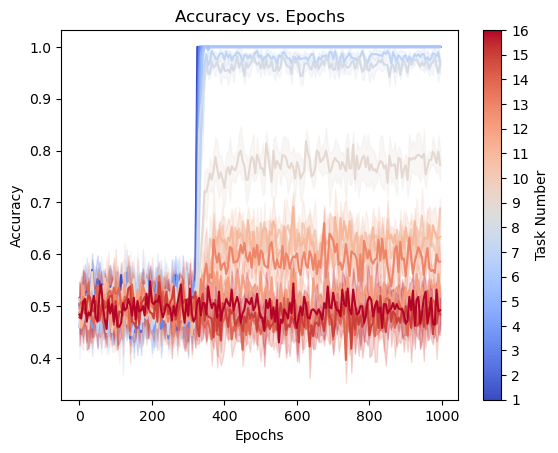

In [93]:
# Creating the task-based accuracy plot.

# Define the moving average window
moving_avg = 5

# Calculate the filtered epochs
epochs = np.arange(0, num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]

# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(accuracy_array[i], (-1, moving_avg))
    #print(len(np.repeat(filtered_epochs, moving_avg)))
    #print(len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()

In [10]:
zipt = []
for i in range(1,16):
    zipt.append(1/i)
zipt_norm = [x / sum(zipt) for x in zipt]
print(zipt_norm)

[0.30136557845783046, 0.15068278922891523, 0.10045519281927681, 0.07534139461445762, 0.06027311569156609, 0.050227596409638406, 0.043052225493975776, 0.03767069730722881, 0.033485064273092266, 0.030136557845783046, 0.027396870768893678, 0.025113798204819203, 0.023181967573679265, 0.021526112746987888, 0.020091038563855364]


In [77]:
# Incase I want to manipulate the earlier run

train_loss_list_copy = train_loss_list
train_accuracy_list_copy = train_accuracy_list
test_loss_list_copy = test_loss_list
test_accuracy_list_copy = test_accuracy_list
accuracy_array_copy = accuracy_array

#STORES DATA FROM THE FIRST 200 EPOCHS.

In [78]:
# DELETE LATER: CODE FOR CONTINUING THE ABOVE PREVIOUS RUN

# This code should be entirely continuing the previous training run. It should not create new data or anything else of the sort.
# Initial results indicate that this is working

# Parameters
n_tasks = 16 # number of tasks created
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 8  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=3, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples_list = [100000] # As shown below, the 1/16th task appears about 1/50 times. So for the rares there are still 100 samples
samples_per_task = 1000
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 500
test_frac = 0.2
num_layers = 8
hidden_size = 256

for num_samples in num_samples_list:
    # Train the model
    #tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message) # Moved intentionally earlier
    #tasks_dict = {'10010000': [4,2,5], '01001011': [1,3,7]}
    #print("tasks_dict = ", tasks_dict.items())
    #[data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    #df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac)

    # Create instances of the neural network
    #model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    #criterion = nn.BCEWithLogitsLoss()
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    #train_dataset = CustomDataset(train_df)
    #test_dataset = CustomDataset(test_df)
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    print(f'{num_samples} samples')

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy

        # Find accuracy data
        tasks_list = list(tasks_dict.keys())
        for i in range(n_tasks):
          task_code = tasks_list[i]
          #print(f"task_code = ", task_code)
          [data_per_task, value_per_task] = generate_dataset_for_task(task_code, samples_per_task)
          #print(data_per_task)
          df_per_task = pd.DataFrame(np.concatenate((data_per_task, value_per_task.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])
          #print(df_per_task)
          dataset_per_task = CustomDataset(df_per_task)
          loader_per_task = DataLoader(dataset_per_task, batch_size=batch_size, shuffle=True)
          model.eval()
          task_correct = 0
          task_total = 0
          with torch.no_grad():
            for inputs, labels in loader_per_task:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                task_correct += (predictions == labels).sum().item()
                task_total += labels.size(0)
                #print(f'inputs = ', inputs)
                #print(f'labels.size(0) = ', labels.size(0))

                #loss = criterion(outputs, labels.unsqueeze(1)) #if in future I want to calculate loss
                #test_loss += loss.item() * inputs.size(0)
            task_accuracy = task_correct / task_total
            #print(f"task_accuracy = ", task_accuracy)
            accuracy_array[(i, epoch)] = task_accuracy
        #print(f"accuracy_array = {accuracy_array} at epoch {epoch}")
        # Print epoch information
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and test losses on the first subplot
    axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot the training and test accuracies on the second subplot
    axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust the spacing between subplots
    #plt.tight_layout()
    plt.suptitle(f'Model performance for {num_samples} data points')
    # Show the subplots
    plt.show()
    
# Display model parameter number. If model is changed, should go into the loop
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

100000 samples


  0%|          | 1/500 [00:31<4:25:59, 31.98s/it]

Epoch 1/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  0%|          | 2/500 [01:02<4:17:34, 31.03s/it]

Epoch 2/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  1%|          | 3/500 [01:33<4:17:14, 31.05s/it]

Epoch 3/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  1%|          | 4/500 [02:14<4:48:59, 34.96s/it]

Epoch 4/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  1%|          | 5/500 [03:07<5:42:35, 41.53s/it]

Epoch 5/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  1%|          | 6/500 [03:43<5:25:35, 39.55s/it]

Epoch 6/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  1%|▏         | 7/500 [04:13<4:59:27, 36.45s/it]

Epoch 7/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  2%|▏         | 8/500 [04:45<4:48:43, 35.21s/it]

Epoch 8/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  2%|▏         | 9/500 [05:16<4:37:32, 33.92s/it]

Epoch 9/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  2%|▏         | 10/500 [05:48<4:30:12, 33.09s/it]

Epoch 10/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  2%|▏         | 11/500 [06:17<4:20:07, 31.92s/it]

Epoch 11/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  2%|▏         | 12/500 [06:48<4:17:02, 31.60s/it]

Epoch 12/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  3%|▎         | 13/500 [07:16<4:07:38, 30.51s/it]

Epoch 13/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  3%|▎         | 14/500 [07:45<4:04:10, 30.15s/it]

Epoch 14/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  3%|▎         | 15/500 [08:14<4:00:04, 29.70s/it]

Epoch 15/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  3%|▎         | 16/500 [08:43<3:59:17, 29.66s/it]

Epoch 16/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  3%|▎         | 17/500 [09:12<3:56:56, 29.43s/it]

Epoch 17/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  4%|▎         | 18/500 [09:41<3:54:11, 29.15s/it]

Epoch 18/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  4%|▍         | 19/500 [10:09<3:52:15, 28.97s/it]

Epoch 19/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  4%|▍         | 20/500 [10:39<3:52:16, 29.04s/it]

Epoch 20/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  4%|▍         | 21/500 [11:07<3:51:02, 28.94s/it]

Epoch 21/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  4%|▍         | 22/500 [11:36<3:50:51, 28.98s/it]

Epoch 22/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  5%|▍         | 23/500 [12:04<3:48:22, 28.73s/it]

Epoch 23/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  5%|▍         | 24/500 [12:33<3:46:51, 28.60s/it]

Epoch 24/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  5%|▌         | 25/500 [13:01<3:45:59, 28.55s/it]

Epoch 25/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  5%|▌         | 26/500 [13:30<3:45:17, 28.52s/it]

Epoch 26/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  5%|▌         | 27/500 [13:58<3:44:48, 28.52s/it]

Epoch 27/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  6%|▌         | 28/500 [14:27<3:44:15, 28.51s/it]

Epoch 28/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  6%|▌         | 29/500 [14:56<3:45:24, 28.71s/it]

Epoch 29/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  6%|▌         | 30/500 [15:24<3:44:08, 28.61s/it]

Epoch 30/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  6%|▌         | 31/500 [15:52<3:42:39, 28.49s/it]

Epoch 31/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  6%|▋         | 32/500 [16:20<3:40:53, 28.32s/it]

Epoch 32/500 - Train Loss: 0.6930 - Test Loss: 0.6930


  7%|▋         | 33/500 [16:49<3:41:51, 28.50s/it]

Epoch 33/500 - Train Loss: 0.6930 - Test Loss: 0.6929


  7%|▋         | 34/500 [17:18<3:40:56, 28.45s/it]

Epoch 34/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  7%|▋         | 35/500 [17:46<3:41:21, 28.56s/it]

Epoch 35/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  7%|▋         | 36/500 [18:14<3:39:32, 28.39s/it]

Epoch 36/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  7%|▋         | 37/500 [18:43<3:39:47, 28.48s/it]

Epoch 37/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  8%|▊         | 38/500 [19:12<3:40:02, 28.58s/it]

Epoch 38/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  8%|▊         | 39/500 [19:40<3:39:14, 28.53s/it]

Epoch 39/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  8%|▊         | 40/500 [20:10<3:42:07, 28.97s/it]

Epoch 40/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  8%|▊         | 41/500 [20:38<3:39:29, 28.69s/it]

Epoch 41/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  8%|▊         | 42/500 [21:07<3:38:20, 28.60s/it]

Epoch 42/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  9%|▊         | 43/500 [21:35<3:37:05, 28.50s/it]

Epoch 43/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  9%|▉         | 44/500 [22:04<3:36:41, 28.51s/it]

Epoch 44/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  9%|▉         | 45/500 [22:32<3:36:17, 28.52s/it]

Epoch 45/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  9%|▉         | 46/500 [23:00<3:34:58, 28.41s/it]

Epoch 46/500 - Train Loss: 0.6929 - Test Loss: 0.6929


  9%|▉         | 47/500 [23:28<3:34:03, 28.35s/it]

Epoch 47/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 10%|▉         | 48/500 [23:57<3:34:08, 28.43s/it]

Epoch 48/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 10%|▉         | 49/500 [24:26<3:34:12, 28.50s/it]

Epoch 49/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 10%|█         | 50/500 [24:54<3:33:08, 28.42s/it]

Epoch 50/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 10%|█         | 51/500 [25:22<3:32:01, 28.33s/it]

Epoch 51/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 10%|█         | 52/500 [25:50<3:31:35, 28.34s/it]

Epoch 52/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 11%|█         | 53/500 [26:19<3:31:55, 28.45s/it]

Epoch 53/500 - Train Loss: 0.6929 - Test Loss: 0.6929


 11%|█         | 54/500 [26:48<3:32:03, 28.53s/it]

Epoch 54/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 11%|█         | 55/500 [27:16<3:30:19, 28.36s/it]

Epoch 55/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 11%|█         | 56/500 [27:45<3:30:47, 28.49s/it]

Epoch 56/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 11%|█▏        | 57/500 [28:13<3:30:21, 28.49s/it]

Epoch 57/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 12%|█▏        | 58/500 [28:42<3:30:53, 28.63s/it]

Epoch 58/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 12%|█▏        | 59/500 [29:11<3:31:25, 28.76s/it]

Epoch 59/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 12%|█▏        | 60/500 [29:40<3:31:38, 28.86s/it]

Epoch 60/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 12%|█▏        | 61/500 [30:09<3:29:58, 28.70s/it]

Epoch 61/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 12%|█▏        | 62/500 [30:37<3:28:47, 28.60s/it]

Epoch 62/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 13%|█▎        | 63/500 [31:05<3:27:59, 28.56s/it]

Epoch 63/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 13%|█▎        | 64/500 [31:33<3:26:26, 28.41s/it]

Epoch 64/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 13%|█▎        | 65/500 [32:02<3:26:11, 28.44s/it]

Epoch 65/500 - Train Loss: 0.6928 - Test Loss: 0.6928


 13%|█▎        | 66/500 [32:32<3:29:04, 28.90s/it]

Epoch 66/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 13%|█▎        | 67/500 [33:01<3:29:05, 28.97s/it]

Epoch 67/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 14%|█▎        | 68/500 [33:30<3:28:35, 28.97s/it]

Epoch 68/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 14%|█▍        | 69/500 [33:58<3:26:09, 28.70s/it]

Epoch 69/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 14%|█▍        | 70/500 [34:26<3:25:01, 28.61s/it]

Epoch 70/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 14%|█▍        | 71/500 [34:55<3:24:17, 28.57s/it]

Epoch 71/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 14%|█▍        | 72/500 [35:25<3:27:01, 29.02s/it]

Epoch 72/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 15%|█▍        | 73/500 [35:54<3:26:41, 29.04s/it]

Epoch 73/500 - Train Loss: 0.6927 - Test Loss: 0.6927


 15%|█▍        | 74/500 [36:22<3:23:01, 28.59s/it]

Epoch 74/500 - Train Loss: 0.6926 - Test Loss: 0.6926


 15%|█▌        | 75/500 [36:51<3:23:28, 28.73s/it]

Epoch 75/500 - Train Loss: 0.6926 - Test Loss: 0.6926


 15%|█▌        | 76/500 [37:19<3:21:48, 28.56s/it]

Epoch 76/500 - Train Loss: 0.6926 - Test Loss: 0.6926


 15%|█▌        | 77/500 [37:47<3:21:02, 28.52s/it]

Epoch 77/500 - Train Loss: 0.6926 - Test Loss: 0.6926


 16%|█▌        | 78/500 [38:15<3:19:11, 28.32s/it]

Epoch 78/500 - Train Loss: 0.6926 - Test Loss: 0.6926


 16%|█▌        | 79/500 [38:45<3:21:01, 28.65s/it]

Epoch 79/500 - Train Loss: 0.6926 - Test Loss: 0.6926


 16%|█▌        | 80/500 [39:13<3:20:32, 28.65s/it]

Epoch 80/500 - Train Loss: 0.6925 - Test Loss: 0.6925


 16%|█▌        | 81/500 [39:42<3:20:20, 28.69s/it]

Epoch 81/500 - Train Loss: 0.6925 - Test Loss: 0.6925


 16%|█▋        | 82/500 [40:11<3:20:35, 28.79s/it]

Epoch 82/500 - Train Loss: 0.6925 - Test Loss: 0.6925


 17%|█▋        | 83/500 [40:39<3:17:53, 28.47s/it]

Epoch 83/500 - Train Loss: 0.6925 - Test Loss: 0.6925


 17%|█▋        | 84/500 [41:07<3:17:24, 28.47s/it]

Epoch 84/500 - Train Loss: 0.6924 - Test Loss: 0.6924


 17%|█▋        | 85/500 [41:36<3:16:44, 28.45s/it]

Epoch 85/500 - Train Loss: 0.6924 - Test Loss: 0.6924


 17%|█▋        | 86/500 [42:04<3:17:08, 28.57s/it]

Epoch 86/500 - Train Loss: 0.6924 - Test Loss: 0.6924


 17%|█▋        | 87/500 [42:33<3:17:26, 28.68s/it]

Epoch 87/500 - Train Loss: 0.6924 - Test Loss: 0.6923


 18%|█▊        | 88/500 [43:03<3:19:07, 29.00s/it]

Epoch 88/500 - Train Loss: 0.6923 - Test Loss: 0.6923


 18%|█▊        | 89/500 [43:32<3:17:43, 28.86s/it]

Epoch 89/500 - Train Loss: 0.6923 - Test Loss: 0.6923


 18%|█▊        | 90/500 [44:00<3:16:33, 28.76s/it]

Epoch 90/500 - Train Loss: 0.6923 - Test Loss: 0.6922


 18%|█▊        | 91/500 [44:29<3:16:04, 28.77s/it]

Epoch 91/500 - Train Loss: 0.6922 - Test Loss: 0.6922


 18%|█▊        | 92/500 [44:57<3:14:51, 28.66s/it]

Epoch 92/500 - Train Loss: 0.6922 - Test Loss: 0.6922


 19%|█▊        | 93/500 [45:25<3:12:34, 28.39s/it]

Epoch 93/500 - Train Loss: 0.6921 - Test Loss: 0.6921


 19%|█▉        | 94/500 [45:54<3:12:00, 28.38s/it]

Epoch 94/500 - Train Loss: 0.6921 - Test Loss: 0.6921


 19%|█▉        | 95/500 [46:22<3:11:37, 28.39s/it]

Epoch 95/500 - Train Loss: 0.6920 - Test Loss: 0.6920


 19%|█▉        | 96/500 [46:51<3:12:31, 28.59s/it]

Epoch 96/500 - Train Loss: 0.6920 - Test Loss: 0.6919


 19%|█▉        | 97/500 [47:19<3:10:20, 28.34s/it]

Epoch 97/500 - Train Loss: 0.6919 - Test Loss: 0.6919


 20%|█▉        | 98/500 [47:48<3:11:13, 28.54s/it]

Epoch 98/500 - Train Loss: 0.6918 - Test Loss: 0.6918


 20%|█▉        | 99/500 [48:17<3:12:48, 28.85s/it]

Epoch 99/500 - Train Loss: 0.6917 - Test Loss: 0.6917


 20%|██        | 100/500 [48:47<3:13:29, 29.02s/it]

Epoch 100/500 - Train Loss: 0.6917 - Test Loss: 0.6916


 20%|██        | 101/500 [49:16<3:12:27, 28.94s/it]

Epoch 101/500 - Train Loss: 0.6916 - Test Loss: 0.6915


 20%|██        | 102/500 [49:47<3:17:41, 29.80s/it]

Epoch 102/500 - Train Loss: 0.6915 - Test Loss: 0.6914


 21%|██        | 103/500 [50:17<3:17:51, 29.90s/it]

Epoch 103/500 - Train Loss: 0.6914 - Test Loss: 0.6913


 21%|██        | 104/500 [50:47<3:16:31, 29.78s/it]

Epoch 104/500 - Train Loss: 0.6912 - Test Loss: 0.6912


 21%|██        | 105/500 [51:17<3:15:52, 29.75s/it]

Epoch 105/500 - Train Loss: 0.6911 - Test Loss: 0.6910


 21%|██        | 106/500 [51:46<3:14:23, 29.60s/it]

Epoch 106/500 - Train Loss: 0.6909 - Test Loss: 0.6908


 21%|██▏       | 107/500 [52:14<3:11:55, 29.30s/it]

Epoch 107/500 - Train Loss: 0.6907 - Test Loss: 0.6906


 22%|██▏       | 108/500 [52:43<3:10:11, 29.11s/it]

Epoch 108/500 - Train Loss: 0.6905 - Test Loss: 0.6904


 22%|██▏       | 109/500 [53:11<3:06:58, 28.69s/it]

Epoch 109/500 - Train Loss: 0.6903 - Test Loss: 0.6901


 22%|██▏       | 110/500 [53:40<3:06:26, 28.68s/it]

Epoch 110/500 - Train Loss: 0.6900 - Test Loss: 0.6898


 22%|██▏       | 111/500 [54:08<3:05:36, 28.63s/it]

Epoch 111/500 - Train Loss: 0.6896 - Test Loss: 0.6894


 22%|██▏       | 112/500 [54:37<3:06:14, 28.80s/it]

Epoch 112/500 - Train Loss: 0.6892 - Test Loss: 0.6890


 23%|██▎       | 113/500 [55:05<3:04:35, 28.62s/it]

Epoch 113/500 - Train Loss: 0.6887 - Test Loss: 0.6884


 23%|██▎       | 114/500 [55:33<3:02:32, 28.37s/it]

Epoch 114/500 - Train Loss: 0.6881 - Test Loss: 0.6877


 23%|██▎       | 115/500 [56:02<3:02:10, 28.39s/it]

Epoch 115/500 - Train Loss: 0.6873 - Test Loss: 0.6869


 23%|██▎       | 116/500 [56:31<3:04:09, 28.77s/it]

Epoch 116/500 - Train Loss: 0.6863 - Test Loss: 0.6858


 23%|██▎       | 117/500 [57:01<3:04:46, 28.95s/it]

Epoch 117/500 - Train Loss: 0.6850 - Test Loss: 0.6842


 24%|██▎       | 118/500 [57:29<3:02:57, 28.74s/it]

Epoch 118/500 - Train Loss: 0.6832 - Test Loss: 0.6821


 24%|██▍       | 119/500 [57:58<3:02:17, 28.71s/it]

Epoch 119/500 - Train Loss: 0.6806 - Test Loss: 0.6790


 24%|██▍       | 120/500 [58:26<3:01:18, 28.63s/it]

Epoch 120/500 - Train Loss: 0.6767 - Test Loss: 0.6741


 24%|██▍       | 121/500 [58:55<3:02:13, 28.85s/it]

Epoch 121/500 - Train Loss: 0.6705 - Test Loss: 0.6660


 24%|██▍       | 122/500 [59:24<3:01:13, 28.77s/it]

Epoch 122/500 - Train Loss: 0.6595 - Test Loss: 0.6512


 25%|██▍       | 123/500 [59:52<2:59:08, 28.51s/it]

Epoch 123/500 - Train Loss: 0.6386 - Test Loss: 0.6218


 25%|██▍       | 124/500 [1:00:20<2:58:18, 28.45s/it]

Epoch 124/500 - Train Loss: 0.5975 - Test Loss: 0.5649


 25%|██▌       | 125/500 [1:00:49<2:58:34, 28.57s/it]

Epoch 125/500 - Train Loss: 0.5190 - Test Loss: 0.4602


 25%|██▌       | 126/500 [1:01:18<2:58:29, 28.63s/it]

Epoch 126/500 - Train Loss: 0.3985 - Test Loss: 0.3261


 25%|██▌       | 127/500 [1:01:47<2:58:41, 28.74s/it]

Epoch 127/500 - Train Loss: 0.2635 - Test Loss: 0.2167


 26%|██▌       | 128/500 [1:02:15<2:56:44, 28.51s/it]

Epoch 128/500 - Train Loss: 0.1535 - Test Loss: 0.1102


 26%|██▌       | 129/500 [1:02:44<2:57:00, 28.63s/it]

Epoch 129/500 - Train Loss: 0.0961 - Test Loss: 0.1025


 26%|██▌       | 130/500 [1:03:12<2:56:08, 28.56s/it]

Epoch 130/500 - Train Loss: 0.0680 - Test Loss: 0.0574


 26%|██▌       | 131/500 [1:03:41<2:56:01, 28.62s/it]

Epoch 131/500 - Train Loss: 0.0530 - Test Loss: 0.0514


 26%|██▋       | 132/500 [1:04:10<2:56:18, 28.75s/it]

Epoch 132/500 - Train Loss: 0.0425 - Test Loss: 0.0361


 27%|██▋       | 133/500 [1:04:38<2:54:20, 28.50s/it]

Epoch 133/500 - Train Loss: 0.0352 - Test Loss: 0.0315


 27%|██▋       | 134/500 [1:05:06<2:54:05, 28.54s/it]

Epoch 134/500 - Train Loss: 0.0300 - Test Loss: 0.0268


 27%|██▋       | 135/500 [1:05:37<2:56:29, 29.01s/it]

Epoch 135/500 - Train Loss: 0.0259 - Test Loss: 0.0281


 27%|██▋       | 136/500 [1:06:06<2:55:57, 29.00s/it]

Epoch 136/500 - Train Loss: 0.0233 - Test Loss: 0.0243


 27%|██▋       | 137/500 [1:06:35<2:56:02, 29.10s/it]

Epoch 137/500 - Train Loss: 0.0209 - Test Loss: 0.0224


 28%|██▊       | 138/500 [1:07:03<2:53:28, 28.75s/it]

Epoch 138/500 - Train Loss: 0.0192 - Test Loss: 0.0197


 28%|██▊       | 139/500 [1:07:31<2:52:41, 28.70s/it]

Epoch 139/500 - Train Loss: 0.0198 - Test Loss: 0.0213


 28%|██▊       | 140/500 [1:08:00<2:52:12, 28.70s/it]

Epoch 140/500 - Train Loss: 0.0167 - Test Loss: 0.0213


 28%|██▊       | 141/500 [1:08:29<2:51:47, 28.71s/it]

Epoch 141/500 - Train Loss: 0.0155 - Test Loss: 0.0204


 28%|██▊       | 142/500 [1:08:58<2:52:41, 28.94s/it]

Epoch 142/500 - Train Loss: 0.0142 - Test Loss: 0.0184


 29%|██▊       | 143/500 [1:09:26<2:50:24, 28.64s/it]

Epoch 143/500 - Train Loss: 0.0134 - Test Loss: 0.0168


 29%|██▉       | 144/500 [1:09:55<2:49:51, 28.63s/it]

Epoch 144/500 - Train Loss: 0.0132 - Test Loss: 0.0222


 29%|██▉       | 145/500 [1:10:24<2:49:30, 28.65s/it]

Epoch 145/500 - Train Loss: 0.0130 - Test Loss: 0.0159


 29%|██▉       | 146/500 [1:10:52<2:49:10, 28.67s/it]

Epoch 146/500 - Train Loss: 0.0132 - Test Loss: 0.0185


 29%|██▉       | 147/500 [1:11:20<2:47:34, 28.48s/it]

Epoch 147/500 - Train Loss: 0.0106 - Test Loss: 0.0174


 30%|██▉       | 148/500 [1:11:50<2:49:24, 28.88s/it]

Epoch 148/500 - Train Loss: 0.0103 - Test Loss: 0.0169


 30%|██▉       | 149/500 [1:12:19<2:48:45, 28.85s/it]

Epoch 149/500 - Train Loss: 0.0093 - Test Loss: 0.0182


 30%|███       | 150/500 [1:12:47<2:47:47, 28.76s/it]

Epoch 150/500 - Train Loss: 0.0096 - Test Loss: 0.0145


 30%|███       | 151/500 [1:13:16<2:47:17, 28.76s/it]

Epoch 151/500 - Train Loss: 0.0098 - Test Loss: 0.0132


 30%|███       | 152/500 [1:13:44<2:45:34, 28.55s/it]

Epoch 152/500 - Train Loss: 0.0079 - Test Loss: 0.0141


 31%|███       | 153/500 [1:14:13<2:44:48, 28.50s/it]

Epoch 153/500 - Train Loss: 0.0074 - Test Loss: 0.0127


 31%|███       | 154/500 [1:14:41<2:44:28, 28.52s/it]

Epoch 154/500 - Train Loss: 0.0074 - Test Loss: 0.0148


 31%|███       | 155/500 [1:15:10<2:44:18, 28.58s/it]

Epoch 155/500 - Train Loss: 0.0069 - Test Loss: 0.0188


 31%|███       | 156/500 [1:15:38<2:43:37, 28.54s/it]

Epoch 156/500 - Train Loss: 0.0060 - Test Loss: 0.0127


 31%|███▏      | 157/500 [1:16:06<2:42:02, 28.35s/it]

Epoch 157/500 - Train Loss: 0.0060 - Test Loss: 0.0133


 32%|███▏      | 158/500 [1:16:35<2:42:34, 28.52s/it]

Epoch 158/500 - Train Loss: 0.0061 - Test Loss: 0.0148


 32%|███▏      | 159/500 [1:17:04<2:42:12, 28.54s/it]

Epoch 159/500 - Train Loss: 0.0051 - Test Loss: 0.0173


 32%|███▏      | 160/500 [1:17:33<2:42:35, 28.69s/it]

Epoch 160/500 - Train Loss: 0.0048 - Test Loss: 0.0180


 32%|███▏      | 161/500 [1:18:02<2:42:12, 28.71s/it]

Epoch 161/500 - Train Loss: 0.0051 - Test Loss: 0.0364


 32%|███▏      | 162/500 [1:18:30<2:41:02, 28.59s/it]

Epoch 162/500 - Train Loss: 0.0042 - Test Loss: 0.0209


 33%|███▎      | 163/500 [1:19:00<2:42:21, 28.91s/it]

Epoch 163/500 - Train Loss: 0.0040 - Test Loss: 0.0122


 33%|███▎      | 164/500 [1:19:28<2:41:07, 28.77s/it]

Epoch 164/500 - Train Loss: 0.0038 - Test Loss: 0.0146


 33%|███▎      | 165/500 [1:19:57<2:41:05, 28.85s/it]

Epoch 165/500 - Train Loss: 0.0035 - Test Loss: 0.0106


 33%|███▎      | 166/500 [1:20:25<2:39:29, 28.65s/it]

Epoch 166/500 - Train Loss: 0.0033 - Test Loss: 0.0121


 33%|███▎      | 167/500 [1:20:55<2:40:20, 28.89s/it]

Epoch 167/500 - Train Loss: 0.0034 - Test Loss: 0.0152


 34%|███▎      | 168/500 [1:21:23<2:39:02, 28.74s/it]

Epoch 168/500 - Train Loss: 0.0028 - Test Loss: 0.0106


 34%|███▍      | 169/500 [1:21:52<2:38:50, 28.79s/it]

Epoch 169/500 - Train Loss: 0.0023 - Test Loss: 0.0107


 34%|███▍      | 170/500 [1:22:21<2:38:14, 28.77s/it]

Epoch 170/500 - Train Loss: 0.0023 - Test Loss: 0.0117


 34%|███▍      | 171/500 [1:22:49<2:36:52, 28.61s/it]

Epoch 171/500 - Train Loss: 0.0021 - Test Loss: 0.0098


 34%|███▍      | 172/500 [1:23:17<2:35:30, 28.45s/it]

Epoch 172/500 - Train Loss: 0.0022 - Test Loss: 0.0109


 35%|███▍      | 173/500 [1:23:45<2:35:08, 28.47s/it]

Epoch 173/500 - Train Loss: 0.0023 - Test Loss: 0.0102


 35%|███▍      | 174/500 [1:24:14<2:34:58, 28.52s/it]

Epoch 174/500 - Train Loss: 0.0017 - Test Loss: 0.0105


 35%|███▌      | 175/500 [1:24:43<2:35:19, 28.68s/it]

Epoch 175/500 - Train Loss: 0.0017 - Test Loss: 0.0099


 35%|███▌      | 176/500 [1:25:11<2:33:11, 28.37s/it]

Epoch 176/500 - Train Loss: 0.0017 - Test Loss: 0.0105


 35%|███▌      | 177/500 [1:25:39<2:33:06, 28.44s/it]

Epoch 177/500 - Train Loss: 0.0015 - Test Loss: 0.0096


 36%|███▌      | 178/500 [1:26:08<2:32:35, 28.43s/it]

Epoch 178/500 - Train Loss: 0.0013 - Test Loss: 0.0105


 36%|███▌      | 179/500 [1:26:37<2:33:33, 28.70s/it]

Epoch 179/500 - Train Loss: 0.0014 - Test Loss: 0.0107


 36%|███▌      | 180/500 [1:27:06<2:33:30, 28.78s/it]

Epoch 180/500 - Train Loss: 0.0012 - Test Loss: 0.0097


 36%|███▌      | 181/500 [1:27:34<2:31:22, 28.47s/it]

Epoch 181/500 - Train Loss: 0.0013 - Test Loss: 0.0103


 36%|███▋      | 182/500 [1:28:03<2:31:44, 28.63s/it]

Epoch 182/500 - Train Loss: 0.0010 - Test Loss: 0.0096


 37%|███▋      | 183/500 [1:28:31<2:31:04, 28.60s/it]

Epoch 183/500 - Train Loss: 0.0011 - Test Loss: 0.0104


 37%|███▋      | 184/500 [1:29:01<2:31:44, 28.81s/it]

Epoch 184/500 - Train Loss: 0.0009 - Test Loss: 0.0107


 37%|███▋      | 185/500 [1:29:29<2:29:51, 28.54s/it]

Epoch 185/500 - Train Loss: 0.0010 - Test Loss: 0.0099


 37%|███▋      | 186/500 [1:29:57<2:29:43, 28.61s/it]

Epoch 186/500 - Train Loss: 0.0009 - Test Loss: 0.0101


 37%|███▋      | 187/500 [1:30:26<2:29:49, 28.72s/it]

Epoch 187/500 - Train Loss: 0.0008 - Test Loss: 0.0100


 38%|███▊      | 188/500 [1:30:55<2:29:06, 28.68s/it]

Epoch 188/500 - Train Loss: 0.0008 - Test Loss: 0.0102


 38%|███▊      | 189/500 [1:31:24<2:29:37, 28.87s/it]

Epoch 189/500 - Train Loss: 0.0008 - Test Loss: 0.0119


 38%|███▊      | 190/500 [1:31:52<2:27:52, 28.62s/it]

Epoch 190/500 - Train Loss: 0.0007 - Test Loss: 0.0104


 38%|███▊      | 191/500 [1:32:21<2:26:52, 28.52s/it]

Epoch 191/500 - Train Loss: 0.0007 - Test Loss: 0.0104


 38%|███▊      | 192/500 [1:32:51<2:29:30, 29.12s/it]

Epoch 192/500 - Train Loss: 0.0007 - Test Loss: 0.0112


 39%|███▊      | 193/500 [1:33:20<2:28:03, 28.94s/it]

Epoch 193/500 - Train Loss: 0.0006 - Test Loss: 0.0103


 39%|███▉      | 194/500 [1:33:48<2:26:54, 28.81s/it]

Epoch 194/500 - Train Loss: 0.0007 - Test Loss: 0.0103


 39%|███▉      | 195/500 [1:34:16<2:25:02, 28.53s/it]

Epoch 195/500 - Train Loss: 0.0006 - Test Loss: 0.0108


 39%|███▉      | 196/500 [1:34:44<2:24:00, 28.42s/it]

Epoch 196/500 - Train Loss: 0.0006 - Test Loss: 0.0106


 39%|███▉      | 197/500 [1:35:12<2:23:17, 28.38s/it]

Epoch 197/500 - Train Loss: 0.0006 - Test Loss: 0.0108


 40%|███▉      | 198/500 [1:35:42<2:24:55, 28.79s/it]

Epoch 198/500 - Train Loss: 0.0006 - Test Loss: 0.0110


 40%|███▉      | 199/500 [1:36:15<2:29:47, 29.86s/it]

Epoch 199/500 - Train Loss: 0.0006 - Test Loss: 0.0107


 40%|████      | 200/500 [1:36:45<2:30:24, 30.08s/it]

Epoch 200/500 - Train Loss: 0.0005 - Test Loss: 0.0100


 40%|████      | 201/500 [1:37:15<2:30:13, 30.15s/it]

Epoch 201/500 - Train Loss: 0.0005 - Test Loss: 0.0107


 40%|████      | 202/500 [1:37:43<2:25:59, 29.39s/it]

Epoch 202/500 - Train Loss: 0.0005 - Test Loss: 0.0111


 41%|████      | 203/500 [1:38:12<2:24:07, 29.11s/it]

Epoch 203/500 - Train Loss: 0.0005 - Test Loss: 0.0109


 41%|████      | 204/500 [1:38:40<2:22:53, 28.97s/it]

Epoch 204/500 - Train Loss: 0.0005 - Test Loss: 0.0110


 41%|████      | 205/500 [1:39:10<2:23:00, 29.09s/it]

Epoch 205/500 - Train Loss: 0.0005 - Test Loss: 0.0105


 41%|████      | 206/500 [1:39:38<2:21:42, 28.92s/it]

Epoch 206/500 - Train Loss: 0.0005 - Test Loss: 0.0109


 41%|████▏     | 207/500 [1:40:06<2:19:59, 28.67s/it]

Epoch 207/500 - Train Loss: 0.0005 - Test Loss: 0.0108


 42%|████▏     | 208/500 [1:40:35<2:19:10, 28.60s/it]

Epoch 208/500 - Train Loss: 0.0005 - Test Loss: 0.0108


 42%|████▏     | 209/500 [1:41:28<2:55:27, 36.18s/it]

Epoch 209/500 - Train Loss: 0.0004 - Test Loss: 0.0113


 42%|████▏     | 210/500 [1:42:23<3:22:07, 41.82s/it]

Epoch 210/500 - Train Loss: 0.0004 - Test Loss: 0.0108


 42%|████▏     | 211/500 [1:43:01<3:14:30, 40.38s/it]

Epoch 211/500 - Train Loss: 0.0004 - Test Loss: 0.0116


 42%|████▏     | 212/500 [1:43:38<3:09:55, 39.57s/it]

Epoch 212/500 - Train Loss: 0.0004 - Test Loss: 0.0102


 43%|████▎     | 213/500 [1:44:12<3:01:06, 37.86s/it]

Epoch 213/500 - Train Loss: 0.0004 - Test Loss: 0.0113


 43%|████▎     | 214/500 [1:44:40<2:45:59, 34.82s/it]

Epoch 214/500 - Train Loss: 0.0004 - Test Loss: 0.0116


 43%|████▎     | 215/500 [1:45:08<2:36:36, 32.97s/it]

Epoch 215/500 - Train Loss: 0.0004 - Test Loss: 0.0110


 43%|████▎     | 216/500 [1:45:37<2:29:27, 31.57s/it]

Epoch 216/500 - Train Loss: 0.0004 - Test Loss: 0.0108


 43%|████▎     | 217/500 [1:46:05<2:24:40, 30.67s/it]

Epoch 217/500 - Train Loss: 0.0004 - Test Loss: 0.0110


 44%|████▎     | 218/500 [1:46:34<2:21:29, 30.10s/it]

Epoch 218/500 - Train Loss: 0.0004 - Test Loss: 0.0105


 44%|████▍     | 219/500 [1:47:02<2:18:15, 29.52s/it]

Epoch 219/500 - Train Loss: 0.0004 - Test Loss: 0.0110


 44%|████▍     | 220/500 [1:47:31<2:16:45, 29.31s/it]

Epoch 220/500 - Train Loss: 0.0004 - Test Loss: 0.0105


 44%|████▍     | 221/500 [1:48:00<2:15:50, 29.21s/it]

Epoch 221/500 - Train Loss: 0.0004 - Test Loss: 0.0105


 44%|████▍     | 222/500 [1:48:30<2:16:54, 29.55s/it]

Epoch 222/500 - Train Loss: 0.0004 - Test Loss: 0.0114


 45%|████▍     | 223/500 [1:49:00<2:16:51, 29.64s/it]

Epoch 223/500 - Train Loss: 0.0004 - Test Loss: 0.0109


 45%|████▍     | 224/500 [1:49:28<2:14:01, 29.14s/it]

Epoch 224/500 - Train Loss: 0.0004 - Test Loss: 0.0109


 45%|████▌     | 225/500 [1:50:00<2:17:44, 30.05s/it]

Epoch 225/500 - Train Loss: 0.0004 - Test Loss: 0.0113


 45%|████▌     | 226/500 [1:50:30<2:17:07, 30.03s/it]

Epoch 226/500 - Train Loss: 0.0004 - Test Loss: 0.0112


 45%|████▌     | 227/500 [1:51:01<2:16:55, 30.09s/it]

Epoch 227/500 - Train Loss: 0.0003 - Test Loss: 0.0109


 46%|████▌     | 228/500 [1:51:30<2:15:20, 29.86s/it]

Epoch 228/500 - Train Loss: 0.0003 - Test Loss: 0.0110


 46%|████▌     | 229/500 [1:51:59<2:13:53, 29.64s/it]

Epoch 229/500 - Train Loss: 0.0003 - Test Loss: 0.0112


 46%|████▌     | 230/500 [1:52:28<2:11:56, 29.32s/it]

Epoch 230/500 - Train Loss: 0.0003 - Test Loss: 0.0111


 46%|████▌     | 231/500 [1:52:56<2:09:44, 28.94s/it]

Epoch 231/500 - Train Loss: 0.0003 - Test Loss: 0.0113


 46%|████▋     | 232/500 [1:53:24<2:08:34, 28.79s/it]

Epoch 232/500 - Train Loss: 0.0003 - Test Loss: 0.0113


 47%|████▋     | 233/500 [1:53:53<2:07:37, 28.68s/it]

Epoch 233/500 - Train Loss: 0.0003 - Test Loss: 0.0117


 47%|████▋     | 234/500 [1:54:21<2:07:14, 28.70s/it]

Epoch 234/500 - Train Loss: 0.0003 - Test Loss: 0.0115


 47%|████▋     | 235/500 [1:54:49<2:05:50, 28.49s/it]

Epoch 235/500 - Train Loss: 0.0003 - Test Loss: 0.0109


 47%|████▋     | 236/500 [1:55:17<2:04:54, 28.39s/it]

Epoch 236/500 - Train Loss: 0.0003 - Test Loss: 0.0113


 47%|████▋     | 237/500 [1:55:46<2:04:26, 28.39s/it]

Epoch 237/500 - Train Loss: 0.0003 - Test Loss: 0.0110


 48%|████▊     | 238/500 [1:56:14<2:04:17, 28.46s/it]

Epoch 238/500 - Train Loss: 0.0003 - Test Loss: 0.0115


 48%|████▊     | 239/500 [1:56:45<2:07:01, 29.20s/it]

Epoch 239/500 - Train Loss: 0.0003 - Test Loss: 0.0116


 48%|████▊     | 240/500 [1:57:14<2:05:19, 28.92s/it]

Epoch 240/500 - Train Loss: 0.0003 - Test Loss: 0.0117


 48%|████▊     | 241/500 [1:57:42<2:03:47, 28.68s/it]

Epoch 241/500 - Train Loss: 0.0003 - Test Loss: 0.0119


 48%|████▊     | 242/500 [1:58:10<2:03:09, 28.64s/it]

Epoch 242/500 - Train Loss: 0.0003 - Test Loss: 0.0114


 49%|████▊     | 243/500 [1:58:39<2:02:43, 28.65s/it]

Epoch 243/500 - Train Loss: 0.0003 - Test Loss: 0.0112


 49%|████▉     | 244/500 [1:59:08<2:03:00, 28.83s/it]

Epoch 244/500 - Train Loss: 0.0003 - Test Loss: 0.0108


 49%|████▉     | 245/500 [1:59:36<2:01:04, 28.49s/it]

Epoch 245/500 - Train Loss: 0.0003 - Test Loss: 0.0112


 49%|████▉     | 246/500 [2:00:05<2:00:41, 28.51s/it]

Epoch 246/500 - Train Loss: 0.0003 - Test Loss: 0.0113


 49%|████▉     | 247/500 [2:00:33<2:00:03, 28.47s/it]

Epoch 247/500 - Train Loss: 0.0003 - Test Loss: 0.0116


 50%|████▉     | 248/500 [2:01:01<1:59:30, 28.46s/it]

Epoch 248/500 - Train Loss: 0.0003 - Test Loss: 0.0119


 50%|████▉     | 249/500 [2:01:30<1:58:44, 28.39s/it]

Epoch 249/500 - Train Loss: 0.0003 - Test Loss: 0.0116


 50%|█████     | 250/500 [2:01:58<1:58:05, 28.34s/it]

Epoch 250/500 - Train Loss: 0.0002 - Test Loss: 0.0126


 50%|█████     | 251/500 [2:02:27<1:58:15, 28.49s/it]

Epoch 251/500 - Train Loss: 0.0003 - Test Loss: 0.0125


 50%|█████     | 252/500 [2:02:55<1:57:53, 28.52s/it]

Epoch 252/500 - Train Loss: 0.0003 - Test Loss: 0.0115


 51%|█████     | 253/500 [2:03:24<1:57:19, 28.50s/it]

Epoch 253/500 - Train Loss: 0.0002 - Test Loss: 0.0129


 51%|█████     | 254/500 [2:03:51<1:55:56, 28.28s/it]

Epoch 254/500 - Train Loss: 0.0002 - Test Loss: 0.0116


 51%|█████     | 255/500 [2:04:26<2:03:20, 30.21s/it]

Epoch 255/500 - Train Loss: 0.0002 - Test Loss: 0.0114


 51%|█████     | 256/500 [2:04:55<2:01:02, 29.76s/it]

Epoch 256/500 - Train Loss: 0.0002 - Test Loss: 0.0117


 51%|█████▏    | 257/500 [2:05:23<1:58:47, 29.33s/it]

Epoch 257/500 - Train Loss: 0.0002 - Test Loss: 0.0116


 52%|█████▏    | 258/500 [2:05:51<1:56:56, 29.00s/it]

Epoch 258/500 - Train Loss: 0.0002 - Test Loss: 0.0111


 52%|█████▏    | 259/500 [2:06:22<1:57:52, 29.35s/it]

Epoch 259/500 - Train Loss: 0.0002 - Test Loss: 0.0115


 52%|█████▏    | 260/500 [2:06:50<1:56:25, 29.11s/it]

Epoch 260/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 52%|█████▏    | 261/500 [2:07:18<1:54:56, 28.85s/it]

Epoch 261/500 - Train Loss: 0.0001 - Test Loss: 0.0112


 52%|█████▏    | 262/500 [2:07:47<1:53:49, 28.69s/it]

Epoch 262/500 - Train Loss: 0.0001 - Test Loss: 0.0118


 53%|█████▎    | 263/500 [2:08:15<1:52:58, 28.60s/it]

Epoch 263/500 - Train Loss: 0.0001 - Test Loss: 0.0115


 53%|█████▎    | 264/500 [2:08:44<1:53:09, 28.77s/it]

Epoch 264/500 - Train Loss: 0.0001 - Test Loss: 0.0112


 53%|█████▎    | 265/500 [2:09:12<1:51:28, 28.46s/it]

Epoch 265/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 53%|█████▎    | 266/500 [2:09:41<1:51:12, 28.51s/it]

Epoch 266/500 - Train Loss: 0.0001 - Test Loss: 0.0115


 53%|█████▎    | 267/500 [2:10:09<1:50:57, 28.57s/it]

Epoch 267/500 - Train Loss: 0.0001 - Test Loss: 0.0115


 54%|█████▎    | 268/500 [2:10:38<1:50:25, 28.56s/it]

Epoch 268/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 54%|█████▍    | 269/500 [2:11:06<1:49:13, 28.37s/it]

Epoch 269/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 54%|█████▍    | 270/500 [2:11:34<1:48:36, 28.33s/it]

Epoch 270/500 - Train Loss: 0.0001 - Test Loss: 0.0115


 54%|█████▍    | 271/500 [2:12:02<1:48:05, 28.32s/it]

Epoch 271/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 54%|█████▍    | 272/500 [2:12:31<1:48:21, 28.52s/it]

Epoch 272/500 - Train Loss: 0.0001 - Test Loss: 0.0115


 55%|█████▍    | 273/500 [2:13:00<1:48:11, 28.60s/it]

Epoch 273/500 - Train Loss: 0.0001 - Test Loss: 0.0114


 55%|█████▍    | 274/500 [2:13:28<1:46:32, 28.29s/it]

Epoch 274/500 - Train Loss: 0.0001 - Test Loss: 0.0118


 55%|█████▌    | 275/500 [2:13:57<1:47:34, 28.69s/it]

Epoch 275/500 - Train Loss: 0.0001 - Test Loss: 0.0118


 55%|█████▌    | 276/500 [2:14:26<1:46:47, 28.60s/it]

Epoch 276/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 55%|█████▌    | 277/500 [2:14:54<1:46:11, 28.57s/it]

Epoch 277/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 56%|█████▌    | 278/500 [2:15:27<1:50:45, 29.94s/it]

Epoch 278/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 56%|█████▌    | 279/500 [2:15:57<1:49:52, 29.83s/it]

Epoch 279/500 - Train Loss: 0.0001 - Test Loss: 0.0117


 56%|█████▌    | 280/500 [2:16:26<1:48:05, 29.48s/it]

Epoch 280/500 - Train Loss: 0.0001 - Test Loss: 0.0118


 56%|█████▌    | 281/500 [2:16:54<1:46:54, 29.29s/it]

Epoch 281/500 - Train Loss: 0.0001 - Test Loss: 0.0117


 56%|█████▋    | 282/500 [2:17:23<1:46:06, 29.20s/it]

Epoch 282/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 57%|█████▋    | 283/500 [2:17:54<1:47:24, 29.70s/it]

Epoch 283/500 - Train Loss: 0.0001 - Test Loss: 0.0117


 57%|█████▋    | 284/500 [2:18:23<1:46:23, 29.55s/it]

Epoch 284/500 - Train Loss: 0.0001 - Test Loss: 0.0116


 57%|█████▋    | 285/500 [2:18:55<1:48:32, 30.29s/it]

Epoch 285/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 57%|█████▋    | 286/500 [2:19:25<1:47:35, 30.16s/it]

Epoch 286/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 57%|█████▋    | 287/500 [2:19:55<1:46:34, 30.02s/it]

Epoch 287/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 58%|█████▊    | 288/500 [2:20:28<1:49:06, 30.88s/it]

Epoch 288/500 - Train Loss: 0.0001 - Test Loss: 0.0117


 58%|█████▊    | 289/500 [2:21:08<1:58:31, 33.70s/it]

Epoch 289/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 58%|█████▊    | 290/500 [2:22:11<2:28:56, 42.55s/it]

Epoch 290/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 58%|█████▊    | 291/500 [2:22:47<2:20:53, 40.45s/it]

Epoch 291/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 58%|█████▊    | 292/500 [2:23:16<2:08:25, 37.05s/it]

Epoch 292/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 59%|█████▊    | 293/500 [2:24:02<2:16:34, 39.59s/it]

Epoch 293/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 59%|█████▉    | 294/500 [2:24:30<2:04:28, 36.25s/it]

Epoch 294/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 59%|█████▉    | 295/500 [2:25:00<1:57:00, 34.25s/it]

Epoch 295/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 59%|█████▉    | 296/500 [2:25:29<1:51:11, 32.71s/it]

Epoch 296/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 59%|█████▉    | 297/500 [2:25:58<1:46:41, 31.53s/it]

Epoch 297/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 60%|█████▉    | 298/500 [2:26:27<1:43:40, 30.79s/it]

Epoch 298/500 - Train Loss: 0.0001 - Test Loss: 0.0118


 60%|█████▉    | 299/500 [2:26:56<1:42:05, 30.47s/it]

Epoch 299/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 60%|██████    | 300/500 [2:27:29<1:43:27, 31.04s/it]

Epoch 300/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 60%|██████    | 301/500 [2:27:59<1:42:22, 30.87s/it]

Epoch 301/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 60%|██████    | 302/500 [2:28:42<1:53:53, 34.51s/it]

Epoch 302/500 - Train Loss: 0.0001 - Test Loss: 0.0118


 61%|██████    | 303/500 [2:29:12<1:48:45, 33.12s/it]

Epoch 303/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 61%|██████    | 304/500 [2:29:41<1:43:41, 31.74s/it]

Epoch 304/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 61%|██████    | 305/500 [2:30:08<1:39:05, 30.49s/it]

Epoch 305/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 61%|██████    | 306/500 [2:30:46<1:45:44, 32.70s/it]

Epoch 306/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 61%|██████▏   | 307/500 [2:31:15<1:41:46, 31.64s/it]

Epoch 307/500 - Train Loss: 0.0001 - Test Loss: 0.0119


 62%|██████▏   | 308/500 [2:31:58<1:52:30, 35.16s/it]

Epoch 308/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 62%|██████▏   | 309/500 [2:32:31<1:49:24, 34.37s/it]

Epoch 309/500 - Train Loss: 0.0001 - Test Loss: 0.0117


 62%|██████▏   | 310/500 [2:33:03<1:46:39, 33.68s/it]

Epoch 310/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 62%|██████▏   | 311/500 [2:33:35<1:44:43, 33.25s/it]

Epoch 311/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 62%|██████▏   | 312/500 [2:34:12<1:47:27, 34.29s/it]

Epoch 312/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 63%|██████▎   | 313/500 [2:34:53<1:52:57, 36.24s/it]

Epoch 313/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 63%|██████▎   | 314/500 [2:35:30<1:53:09, 36.50s/it]

Epoch 314/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 63%|██████▎   | 315/500 [2:36:01<1:47:43, 34.94s/it]

Epoch 315/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 63%|██████▎   | 316/500 [2:36:33<1:44:06, 33.95s/it]

Epoch 316/500 - Train Loss: 0.0001 - Test Loss: 0.0126


 63%|██████▎   | 317/500 [2:37:07<1:43:30, 33.94s/it]

Epoch 317/500 - Train Loss: 0.0001 - Test Loss: 0.0120


 64%|██████▎   | 318/500 [2:37:38<1:40:42, 33.20s/it]

Epoch 318/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 64%|██████▍   | 319/500 [2:38:11<1:39:49, 33.09s/it]

Epoch 319/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 64%|██████▍   | 320/500 [2:38:40<1:35:27, 31.82s/it]

Epoch 320/500 - Train Loss: 0.0001 - Test Loss: 0.0125


 64%|██████▍   | 321/500 [2:39:13<1:35:57, 32.17s/it]

Epoch 321/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 64%|██████▍   | 322/500 [2:39:41<1:31:45, 30.93s/it]

Epoch 322/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 65%|██████▍   | 323/500 [2:40:08<1:27:37, 29.70s/it]

Epoch 323/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 65%|██████▍   | 324/500 [2:40:37<1:26:38, 29.54s/it]

Epoch 324/500 - Train Loss: 0.0001 - Test Loss: 0.0126


 65%|██████▌   | 325/500 [2:41:06<1:25:30, 29.32s/it]

Epoch 325/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 65%|██████▌   | 326/500 [2:41:35<1:25:02, 29.33s/it]

Epoch 326/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 65%|██████▌   | 327/500 [2:42:07<1:26:38, 30.05s/it]

Epoch 327/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 66%|██████▌   | 328/500 [2:42:35<1:24:15, 29.40s/it]

Epoch 328/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 66%|██████▌   | 329/500 [2:43:03<1:22:24, 28.92s/it]

Epoch 329/500 - Train Loss: 0.0001 - Test Loss: 0.0125


 66%|██████▌   | 330/500 [2:43:31<1:21:13, 28.67s/it]

Epoch 330/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 66%|██████▌   | 331/500 [2:43:59<1:20:52, 28.71s/it]

Epoch 331/500 - Train Loss: 0.0001 - Test Loss: 0.0125


 66%|██████▋   | 332/500 [2:44:29<1:20:41, 28.82s/it]

Epoch 332/500 - Train Loss: 0.0001 - Test Loss: 0.0126


 67%|██████▋   | 333/500 [2:44:56<1:19:09, 28.44s/it]

Epoch 333/500 - Train Loss: 0.0001 - Test Loss: 0.0124


 67%|██████▋   | 334/500 [2:45:24<1:18:22, 28.33s/it]

Epoch 334/500 - Train Loss: 0.0001 - Test Loss: 0.0125


 67%|██████▋   | 335/500 [2:45:53<1:18:01, 28.37s/it]

Epoch 335/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 67%|██████▋   | 336/500 [2:46:22<1:18:31, 28.73s/it]

Epoch 336/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 67%|██████▋   | 337/500 [2:46:52<1:18:51, 29.03s/it]

Epoch 337/500 - Train Loss: 0.0001 - Test Loss: 0.0121


 68%|██████▊   | 338/500 [2:47:20<1:17:28, 28.69s/it]

Epoch 338/500 - Train Loss: 0.0001 - Test Loss: 0.0125


 68%|██████▊   | 339/500 [2:47:50<1:18:01, 29.08s/it]

Epoch 339/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 68%|██████▊   | 340/500 [2:48:20<1:18:04, 29.28s/it]

Epoch 340/500 - Train Loss: 0.0001 - Test Loss: 0.0122


 68%|██████▊   | 341/500 [2:48:50<1:18:36, 29.67s/it]

Epoch 341/500 - Train Loss: 0.0001 - Test Loss: 0.0123


 68%|██████▊   | 342/500 [2:49:21<1:18:43, 29.89s/it]

Epoch 342/500 - Train Loss: 0.0001 - Test Loss: 0.0127


 68%|██████▊   | 342/500 [2:49:23<1:18:15, 29.72s/it]


KeyboardInterrupt: 

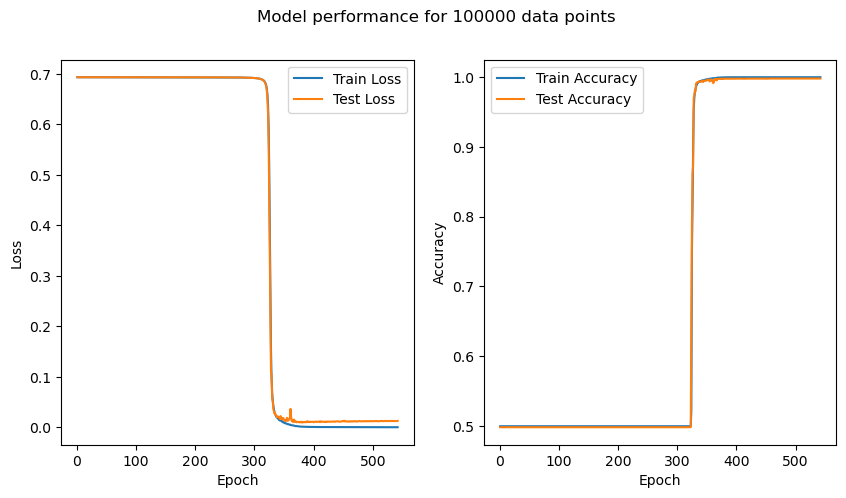

270
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540


C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\AppData\Local\Temp\ipykernel_24368\1112941342.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')


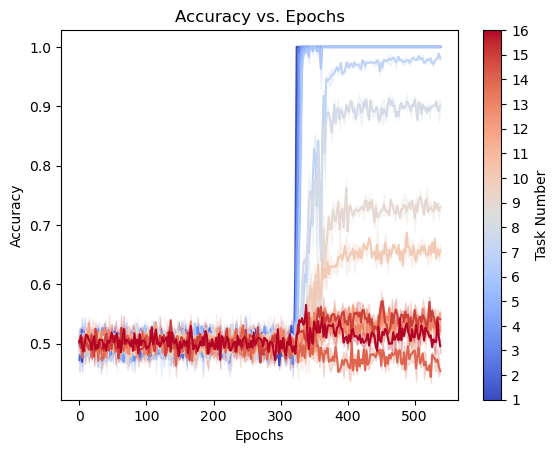

In [90]:
# Used for stitching together two separate training runs. Useful if a prior run was terminatedd earlier than is optimal.

#num_epochs = len(train_accuracy_list_copy) + len(train_accuracy_list)
first_run_epochs = 200
second_run_epochs = 342
num_epochs = first_run_epochs + second_run_epochs

full_train_accuracy = np.concatenate((train_accuracy_list_copy, train_accuracy_list[:second_run_epochs]), axis=0)
full_test_accuracy = np.concatenate((test_accuracy_list_copy, test_accuracy_list[:second_run_epochs]))
full_train_loss = np.concatenate((train_loss_list_copy, train_loss_list[:second_run_epochs]))
full_test_loss = np.concatenate((test_loss_list_copy, test_loss_list[:second_run_epochs]))
full_accuracy_array = np.concatenate((accuracy_array_copy, accuracy_array[:,:second_run_epochs-2]), axis=1)

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and test losses on the first subplot
axs[0].plot(range(1, num_epochs+1), full_train_loss, label='Train Loss')
axs[0].plot(range(1, num_epochs+1), full_test_loss, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and test accuracies on the second subplot
axs[1].plot(range(1, num_epochs+1), full_train_accuracy, label='Train Accuracy')
axs[1].plot(range(1, num_epochs+1), full_test_accuracy, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle(f'Model performance for {num_samples} data points')
# Show the subplots
plt.show()
#########################################################
# Define the moving average window
moving_avg = 2

# Calculate the filtered epochs
epochs = np.arange(0, num_epochs, moving_avg)
filtered_epochs = epochs[:len(epochs)//moving_avg * moving_avg]
print(len(filtered_epochs))
# Create an empty DataFrame
df = pd.DataFrame()

# Loop over the tasks and reshape the accuracy array
for i in range(n_tasks): # THere is strange bug I don't understand when moving_avg is certain values, such as 4
    reshaped_accuracy_array = np.reshape(full_accuracy_array[i], (-1, moving_avg))
    print(len(np.repeat(filtered_epochs, moving_avg)))
    print(len(np.ndarray.flatten(reshaped_accuracy_array)))
    # Create a temporary DataFrame for the current task
    temp_df = pd.DataFrame({
        'Epochs': np.repeat(filtered_epochs, moving_avg),
        'Accuracy': np.ndarray.flatten(reshaped_accuracy_array),
        'Task': i + 1
    })
    
    # Concatenate the temporary DataFrame to the main DataFrame
    df = pd.concat([df, temp_df])
    
# Create a colourbar plot for different tasks, in seaborn. Useful for smoothing stuff out a bit.
# It was getting a bit hard to read with the very high variability.

# Define the color map
color_map = 'coolwarm'  # Change the color map here

# Plotting the data using seaborn
sns.lineplot(data=df, x='Epochs', y='Accuracy', errorbar=('ci', 95), estimator='mean', hue='Task', palette=color_map)

# Add plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')

sm = plt.cm.ScalarMappable(cmap=color_map)
sm.set_array(range(1, n_tasks + 1))
#plt.colorbar(sm, ticks=np.arange(1, n_tasks + 1, int(n_tasks+1)/10), label='Task Number')
plt.colorbar(sm, ticks=np.linspace(1, n_tasks + 2, n_tasks+1, dtype=int), label='Task Number')

# Remove the legend inside the plot
plt.legend().remove()

# Show the plot
plt.show()